
# Train-test split for linear regression with `pymc3`

_Author: Christoph Rahmede_

A good way to test Bayesian models is through a test set. Doing so requires diving a bit more into the syntax of the Theano backend and shared variables.

We will see how to set up shared variables and how to switch between train and test sets in the different formulations of linear regression with pymc3.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-1">Get the data</a></span></li><li><span><a href="#Create-a-train-test-split" data-toc-modified-id="Create-a-train-test-split-2">Create a train test split</a></span></li><li><span><a href="#Standardize-the-data" data-toc-modified-id="Standardize-the-data-3">Standardize the data</a></span></li><li><span><a href="#Simple-Linear-Regression---explicit-setup" data-toc-modified-id="Simple-Linear-Regression---explicit-setup-4">Simple Linear Regression - explicit setup</a></span><ul class="toc-item"><li><span><a href="#Create-a-shared-Theano-variable" data-toc-modified-id="Create-a-shared-Theano-variable-4.1">Create a shared Theano variable</a></span></li><li><span><a href="#Training-set-evaluation" data-toc-modified-id="Training-set-evaluation-4.2">Training set evaluation</a></span></li><li><span><a href="#Test-set-evaluation" data-toc-modified-id="Test-set-evaluation-4.3">Test set evaluation</a></span></li></ul></li><li><span><a href="#Simple-Linear-Regression---GLM-formulation" data-toc-modified-id="Simple-Linear-Regression---GLM-formulation-5">Simple Linear Regression - GLM formulation</a></span><ul class="toc-item"><li><span><a href="#Evaluation-on-the-training-set" data-toc-modified-id="Evaluation-on-the-training-set-5.1">Evaluation on the training set</a></span></li><li><span><a href="#Evaluation-on-the-test-set" data-toc-modified-id="Evaluation-on-the-test-set-5.2">Evaluation on the test set</a></span></li></ul></li><li><span><a href="#Simple-Linear-Regression---GLM-formulation-from-formula" data-toc-modified-id="Simple-Linear-Regression---GLM-formulation-from-formula-6">Simple Linear Regression - GLM formulation from formula</a></span><ul class="toc-item"><li><span><a href="#Evaluation-on-the-training-set" data-toc-modified-id="Evaluation-on-the-training-set-6.1">Evaluation on the training set</a></span></li><li><span><a href="#Evaluation-on-the-test-set" data-toc-modified-id="Evaluation-on-the-test-set-6.2">Evaluation on the test set</a></span></li></ul></li><li><span><a href="#Multivariate-Linear-Regression---explicit-formulation" data-toc-modified-id="Multivariate-Linear-Regression---explicit-formulation-7">Multivariate Linear Regression - explicit formulation</a></span><ul class="toc-item"><li><span><a href="#Evaluation-on-the-training-set" data-toc-modified-id="Evaluation-on-the-training-set-7.1">Evaluation on the training set</a></span></li><li><span><a href="#Evaluation-on-the-test-set" data-toc-modified-id="Evaluation-on-the-test-set-7.2">Evaluation on the test set</a></span></li></ul></li><li><span><a href="#Multivariate-Linear-Regression---GLM-formulation" data-toc-modified-id="Multivariate-Linear-Regression---GLM-formulation-8">Multivariate Linear Regression - GLM formulation</a></span><ul class="toc-item"><li><span><a href="#Evaluation-on-the-training-set" data-toc-modified-id="Evaluation-on-the-training-set-8.1">Evaluation on the training set</a></span></li><li><span><a href="#Evaluation-on-the-test-set" data-toc-modified-id="Evaluation-on-the-test-set-8.2">Evaluation on the test set</a></span></li></ul></li></ul></div>

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=4)
pd.set_option('precision', 4)

sns.set(font_scale=1.5)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
import pymc3 as pm
import arviz as az

## Get the data

In [10]:
df = pd.read_csv(
    '/Users/maartenk/Documents/git/DsMasterClass/dataset-collection/auto-mpg/auto-mpg.csv', sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(3), object(2)
memory usage: 33.7+ KB


In [11]:
df['american'] = df.origin.map(lambda x: 1 if x == 1 else 0)
df['european'] = df.origin.map(lambda x: 1 if x == 2 else 0)
df['asian'] = df.origin.map(lambda x: 1 if x == 3 else 0)

american_mpg = df.mpg[df.american == 1]
european_mpg = df.mpg[df.european == 1]
asian_mpg = df.mpg[df.asian == 1]

## Create a train test split

In [12]:
from sklearn.model_selection import train_test_split

target = 'mpg'
y = df[target]
predictors = [col for col in df.columns if col not in [
    target, 'origin', 'name', 'brand', 'asian']]

X_train, X_test, y_train, y_test = train_test_split(
    df[predictors], y, test_size=0.2, random_state=1)

## Standardize the data

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=predictors)
X_test = pd.DataFrame(scaler.transform(X_test), columns=predictors)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


## Simple Linear Regression - explicit setup

### Create a shared Theano variable

We refer to this shared variable for the observed predictor data. 
We can change what is contained in this variable later. In this way we can exchange between train and test sets.

In [15]:
from theano import shared

predictor_one = ['horsepower']
target = 'mpg'

predictors_shared = shared(X_train[predictor_one].values)
outcome_shared = shared(y_train.values)

The Theano objects are not very informative.

In [16]:
predictors_shared, outcome_shared

(<TensorType(float64, matrix)>, <TensorType(float64, vector)>)

We can inquire about the current values and shapes.

In [17]:
predictors_shared.get_value()[:10, 0]

array([-0.5   ,  0.1868, -0.5264, -1.0019, -0.7642,  1.9037,  0.1868,
       -0.9491, -0.6057, -0.9491])

In [18]:
outcome_shared.get_value()[:10]

array([27.2, 18.6, 29. , 37.2, 33. , 13. , 22.4, 44.6, 27.4, 31. ])

In [19]:
predictors_shared.get_value().shape

(313, 1)

In [20]:
outcome_shared.get_value().shape

(313,)

In the model, we refer to the shared variables.

In [21]:
with pm.Model() as model:

    std = pm.Uniform('error_std', lower=0.0001, upper=1000.)
    intercept = pm.Normal('intercept', mu=0., sd=100)
    beta = pm.Normal('beta', mu=0., sd=100, shape=1)

    y_hat = pm.Normal('y',
                      # refer to the shared predictor and outcome variables
                      mu=intercept + pm.math.dot(predictors_shared, beta),
                      sd=std,
                      observed=outcome_shared.T)

We can see the model setup, but the Theano objects do not fit into the graphical model representation.

In [22]:
model

In [23]:
with model:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, error_std]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3842.50draws/s]


In [24]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,23.3998,0.2766,0.0038,22.8627,23.9431,6443.2743,0.9996
beta__0,-5.9728,0.2694,0.0033,-6.5166,-5.4597,6442.4798,0.9996
error_std,4.8101,0.1899,0.0024,4.4448,5.1808,5857.0456,1.0004


### Training set evaluation

We create posterior predictive samples from the trace and the model, evaluate the mean predicted values against the true values, determine the highest posterior density intervals for each prediction and plot the true versus the predicted values. The same we will do for the test set.

In [25]:
from sklearn.metrics import r2_score

(array([ 1.,  4.,  4., 16., 30., 45., 67., 87., 44., 15.]),
 array([-4.5208, -0.1966,  4.1277,  8.4519, 12.7761, 17.1004, 21.4246,
        25.7489, 30.0731, 34.3973, 38.7216]),
 <a list of 10 Patch objects>)

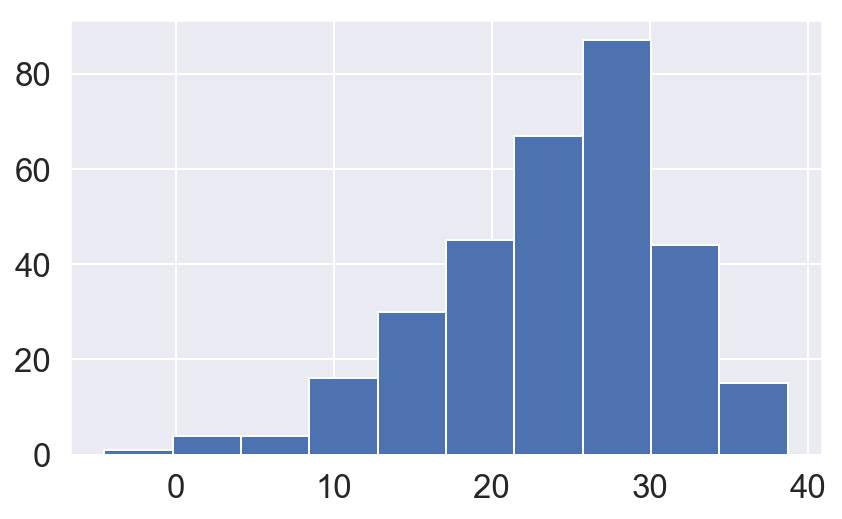

In [30]:
plt.hist(preds['y'][0])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


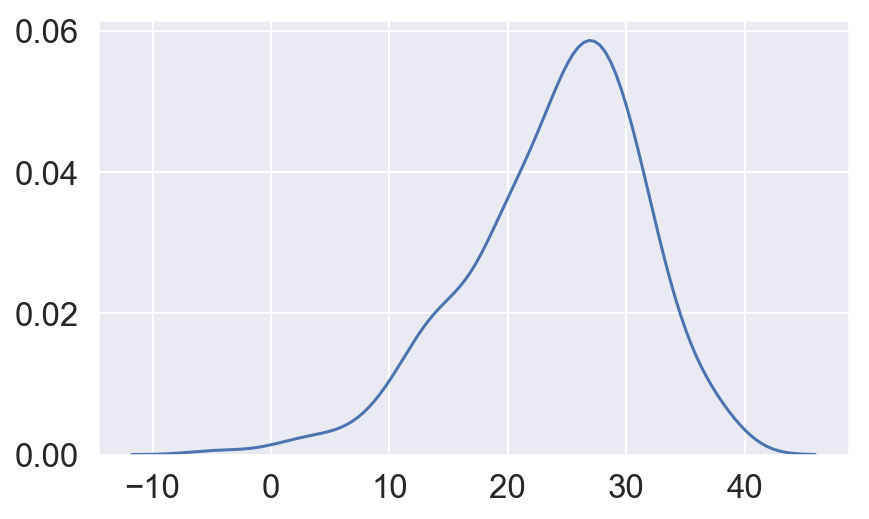

In [32]:
sns.kdeplot(preds['y'][0])

In [28]:
# obtain in-sample forecasts
def prediction_scoring(y, trace, model, var_name='y', samples=1000):
    preds = pm.sample_posterior_predictive(trace, model=model, samples=samples)

    predictions = preds[var_name].mean(axis=0)
    hpds = np.apply_along_axis(pm.hpd, 0, preds[var_name]).T

    print('sklearn r2:', r2_score(y, predictions))
    print('pym3 r2:', pm.r2_score(y, preds[var_name], round_to=6).r2_mean)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(predictions, y)
    for i in range(len(y)):
        ax.vlines(predictions[i], hpds[i, 0], hpds[i, 1], alpha=0.2)
    ax.set_xlabel('y_hat')
    ax.set_ylabel('y')

    return preds, fig, ax

100%|██████████| 1000/1000 [00:08<00:00, 129.38it/s]


sklearn r2: 0.6102425464983727
pym3 r2: 0.560743


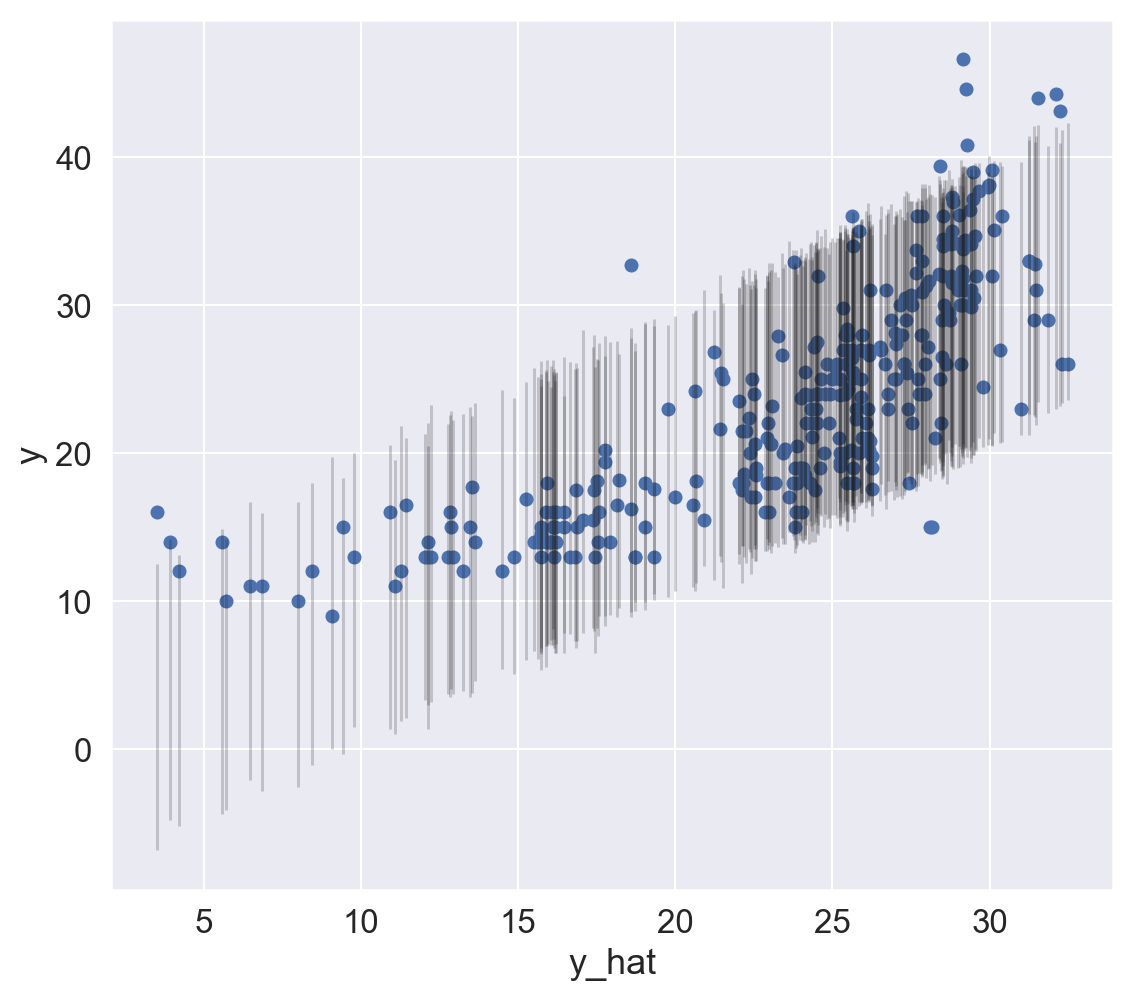

In [29]:
preds, fig, ax = prediction_scoring(y_train.values, trace, model)

### Test set evaluation

In [21]:
# update the shared predictor variable referring to the test data
predictors_shared.set_value(X_test[predictor_one].values)
outcome_shared.set_value(y_test.values)

In [22]:
predictors_shared.get_value().shape

(79, 1)

In [23]:
outcome_shared.get_value().shape

(79,)

100%|██████████| 1000/1000 [00:10<00:00, 94.86it/s]


sklearn r2: 0.5853577029756787
pym3 r2: 0.559287


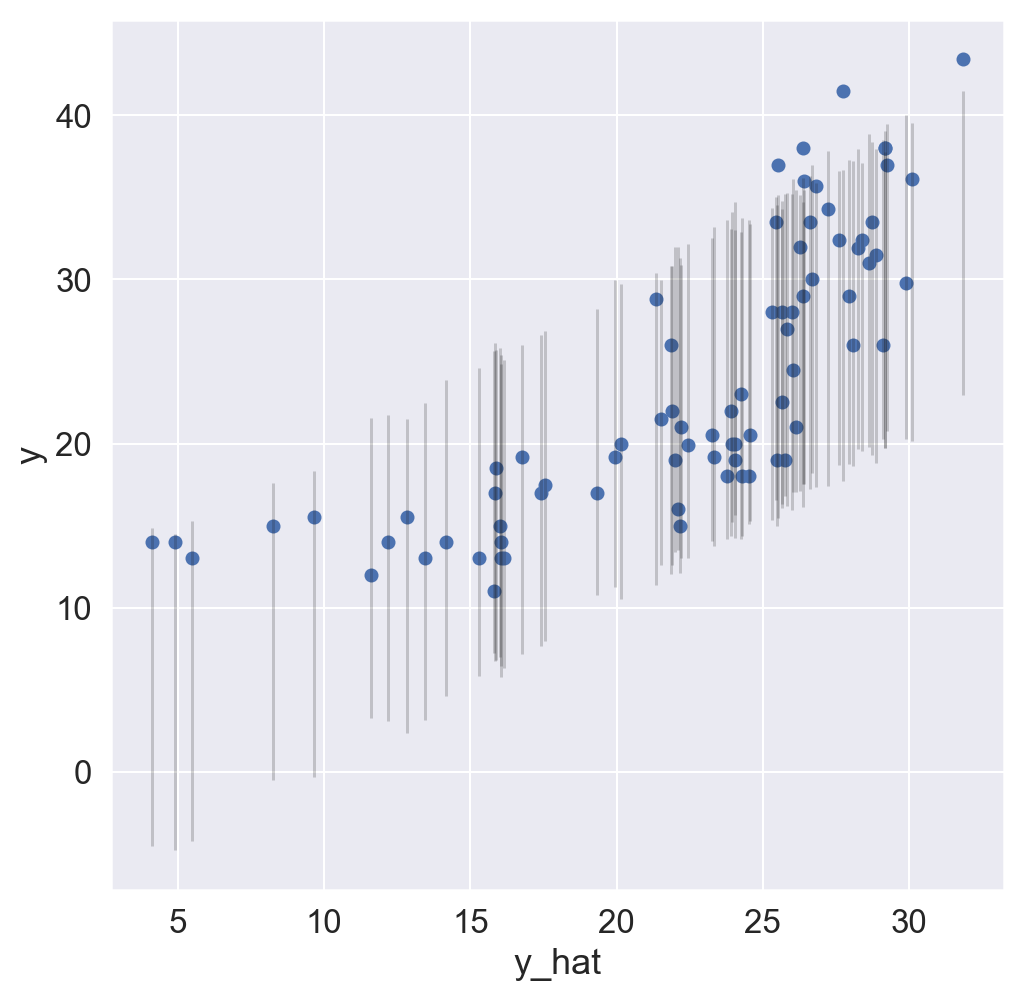

In [24]:
preds, fig, ax = prediction_scoring(y_test.values, trace, model)

## Simple Linear Regression - GLM formulation

In [25]:
predictors_shared = shared(X_train[predictor_one].values)
outcome_shared = shared(y_train.values)

In [26]:
# this now makes use of the shared variable
with pm.Model() as model:

    # labels are required to create keys for the variables in the trace dictionaries
    pm.glm.GLM(predictors_shared, y=outcome_shared, labels=predictor_one)

    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, horsepower, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 756.68draws/s] 


### Evaluation on the training set

100%|██████████| 1000/1000 [00:13<00:00, 76.62it/s]


sklearn r2: 0.6087993377356306
pym3 r2: 0.560831


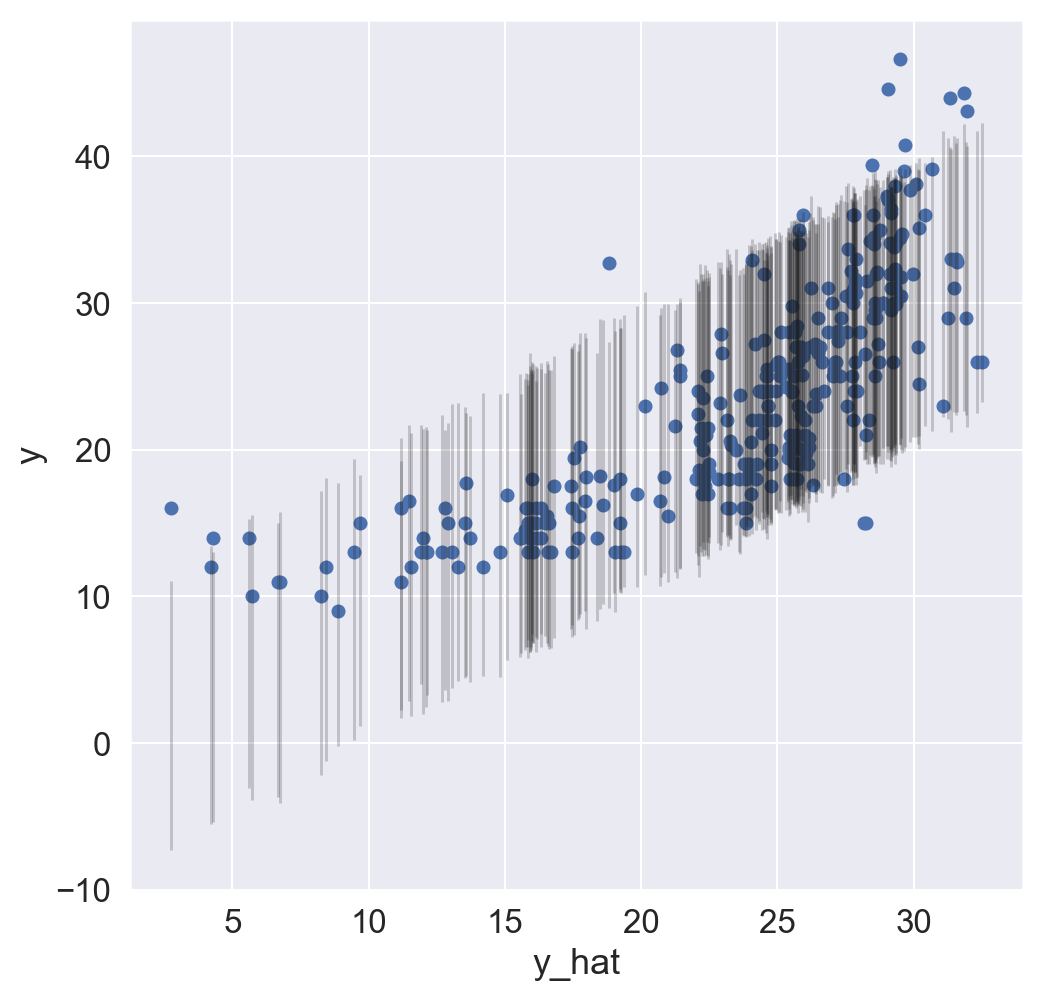

In [27]:
preds, fig, ax = prediction_scoring(y_train.values, trace, model)

### Evaluation on the test set

In [28]:
# update the shared predictor variable referring to the test data
predictors_shared.set_value(X_test[predictor_one].values)
outcome_shared.set_value(y_test.values)

In [29]:
predictors_shared.get_value().shape

(79, 1)

100%|██████████| 1000/1000 [00:11<00:00, 87.99it/s]


sklearn r2: 0.5861792356789374
pym3 r2: 0.559164


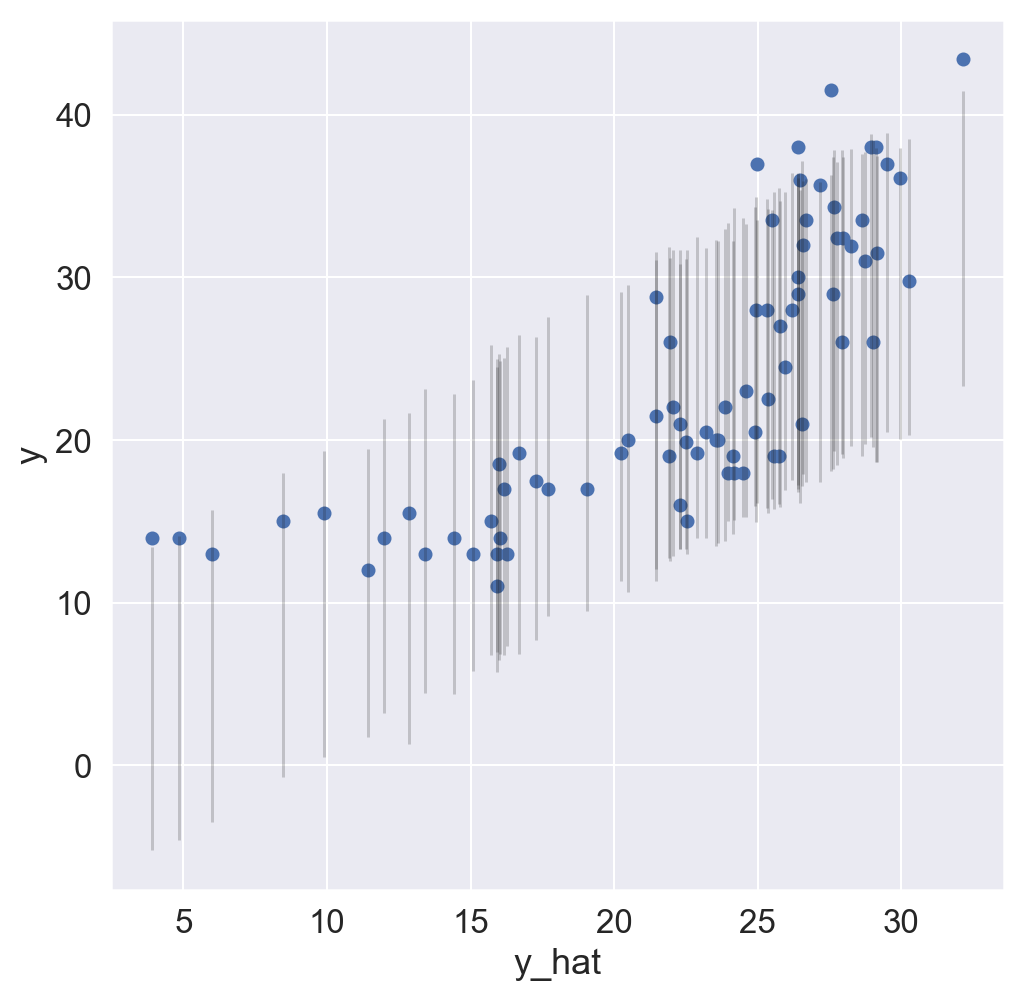

In [30]:
preds, fig, ax = prediction_scoring(y_test.values, trace, model)

## Simple Linear Regression - GLM formulation from formula

In [31]:
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,year,american,european
0,-0.8256,-0.5318,-0.5000,-0.5562,-0.0016,1.3818,0.7939,-0.4719
1,0.3517,0.3462,0.1868,0.7776,1.1009,0.5642,0.7939,-0.4719
2,-0.8256,-0.8927,-0.5264,-0.8760,0.2924,-0.5259,-1.2597,2.1193
3,-0.8256,-1.0098,-1.0019,-1.1121,0.2556,1.1092,-1.2597,-0.4719
4,-0.8256,-0.8244,-0.7642,-0.9102,-0.5529,1.3818,-1.2597,2.1193


In [32]:
X_train['mpg'] = y_train.values
X_test['mpg'] = y_test.values

When using the formula setup, the outcome and predictor variables have to be contained in the same dataset.

In [33]:
variables_shared = shared(X_train)

In [34]:
formula = target + ' ~ ' + ('+').join(predictor_one)
formula

'mpg ~ horsepower'

In [35]:
# this now makes use of the shared variable
with pm.Model() as model:

    pm.glm.GLM.from_formula(formula, variables_shared.get_value())

    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, horsepower, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1007.32draws/s]


### Evaluation on the training set

100%|██████████| 1000/1000 [00:00<00:00, 1440.43it/s]


sklearn r2: 0.610374710045265
pym3 r2: 0.562124


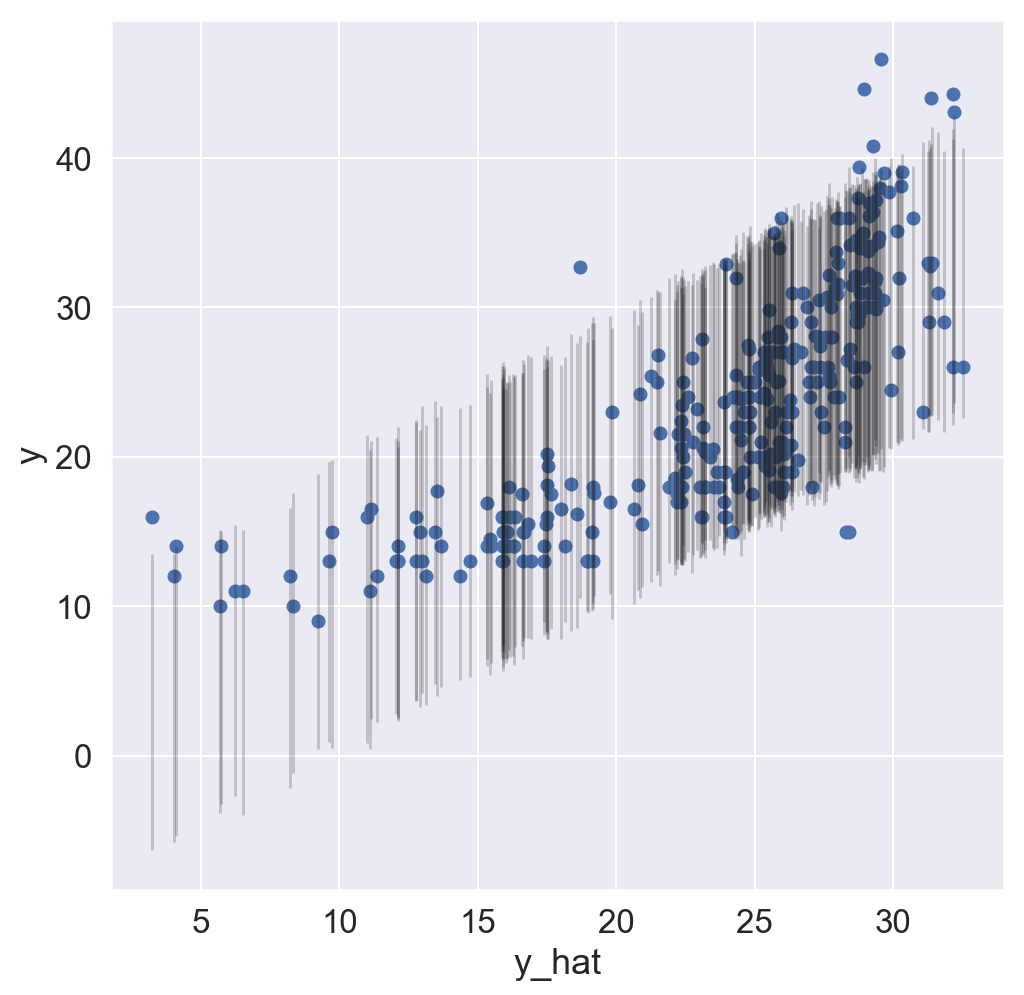

In [36]:
preds, fig, ax = prediction_scoring(y_train.values, trace, model)

### Evaluation on the test set

In [37]:
# update the shared predictor variable referring to the test data
variables_shared.set_value(X_test)
outcome_shared.set_value(y_test.values)
variables_shared.get_value().shape

(79, 9)

This model fails to recognize the updated variable!

In [38]:
ppc = pm.sample_posterior_predictive(trace, model=model, samples=5000)
print(ppc['y'].shape)

100%|██████████| 5000/5000 [00:03<00:00, 1613.08it/s]

(5000, 313)


## Multivariate Linear Regression - explicit formulation

In [39]:
# remove the outcome variable from the predictors
predictors = [x for x in predictors if x != 'mpg']

In [40]:
from theano import shared

predictors_shared = shared(X_train[predictors].values)
outcome_shared = shared(y_train.values)

In [41]:
len(predictors)

8

In [42]:
with pm.Model() as model:

    std = pm.Uniform('error_std', lower=0.0001, upper=1000.)
    intercept = pm.Normal('intercept', mu=y_train.mean(), sd=100)
    beta = pm.Normal('beta', mu=0, sd=100, shape=len(predictors))

    y_hat = pm.Normal('y',
                      # refer to the shared predictor variable
                      mu=intercept + pm.math.dot(predictors_shared, beta),
                      sd=std,
                      observed=outcome_shared)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, error_std]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 386.68draws/s]


### Evaluation on the training set

100%|██████████| 1000/1000 [00:09<00:00, 100.02it/s]


sklearn r2: 0.8202857277205875
pym3 r2: 0.731538


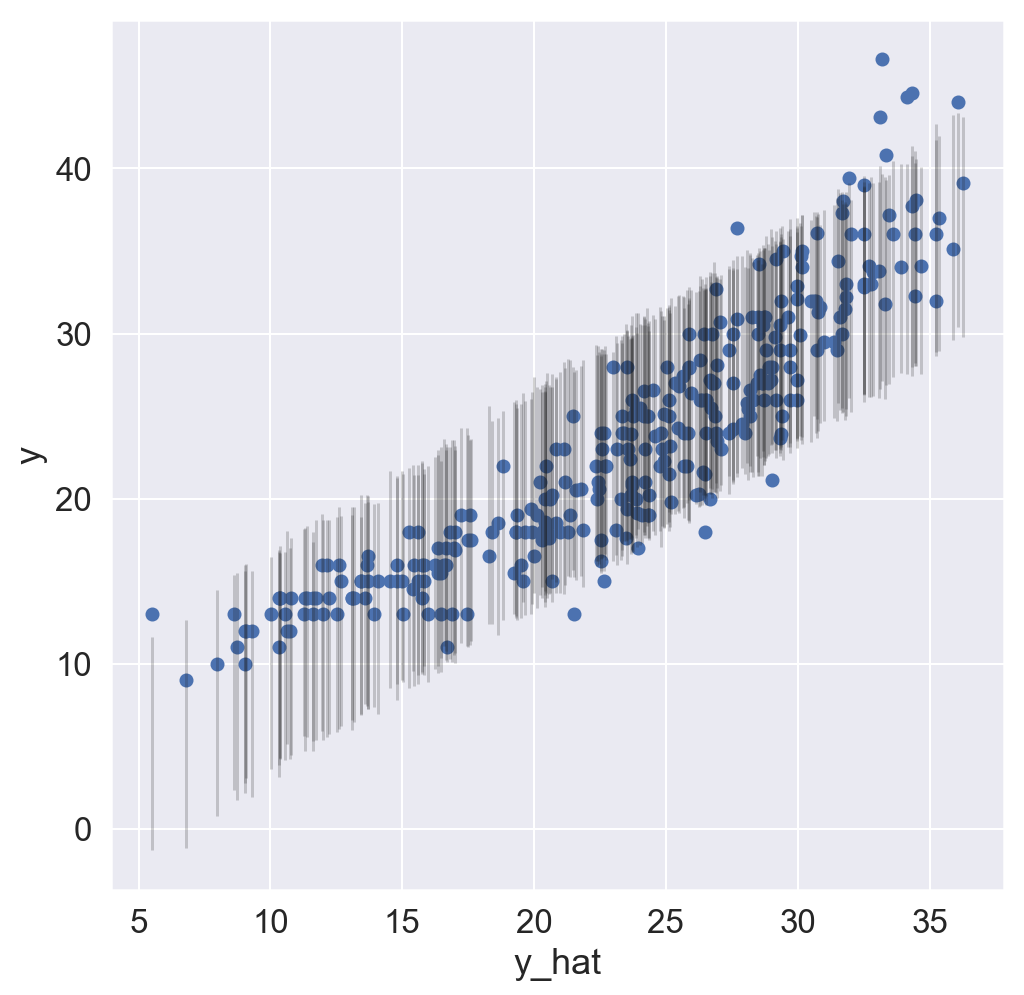

In [43]:
preds, fig, ax = prediction_scoring(y_train.values, trace, model)

### Evaluation on the test set

In [44]:
# update the shared predictor variable referring to the test data
predictors_shared.set_value(X_test[predictors].values)
outcome_shared.set_value(y_test.values)

100%|██████████| 1000/1000 [00:09<00:00, 101.37it/s]


sklearn r2: 0.8301666455475605
pym3 r2: 0.739386


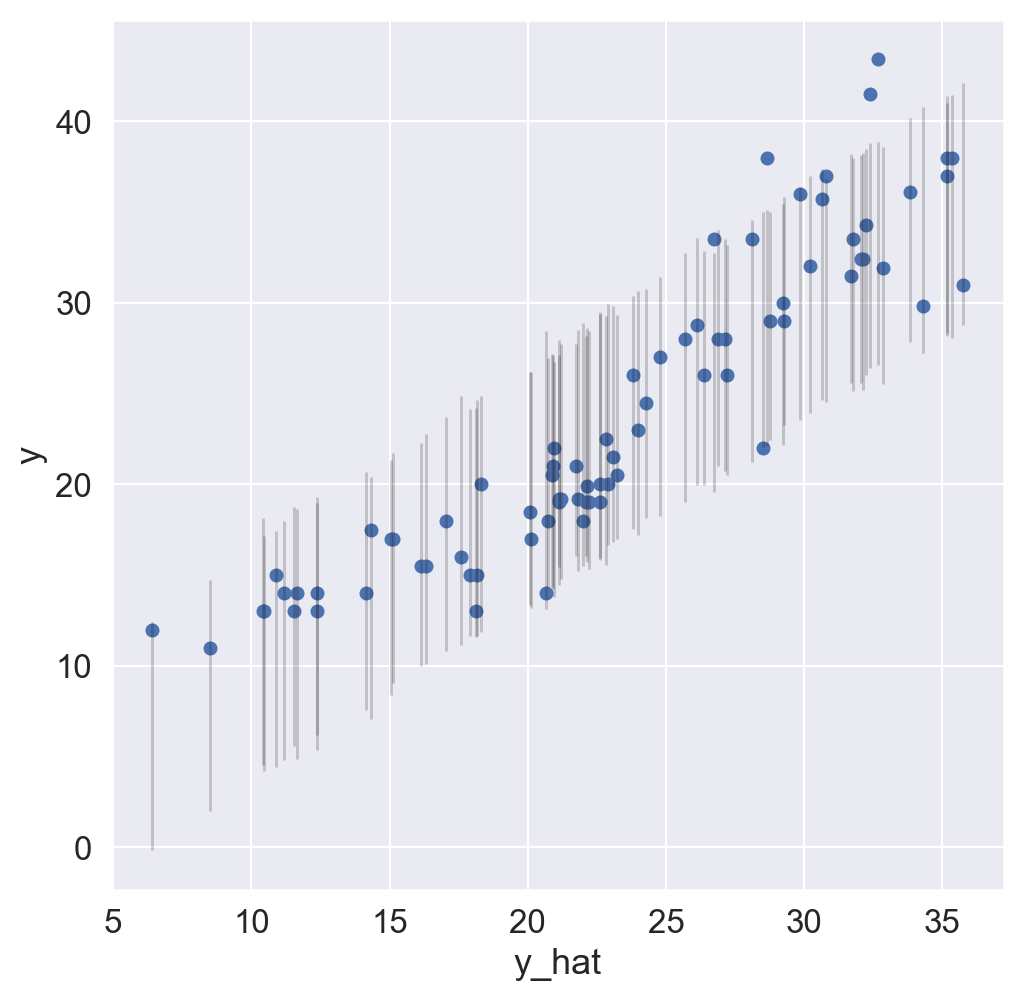

In [45]:
preds, fig, ax = prediction_scoring(y_test.values, trace, model)

## Multivariate Linear Regression - GLM formulation

In [46]:
predictors_shared = shared(X_train[predictors].values)
outcome_shared = shared(y_train.values)

In [47]:
# this now makes use of the shared variable
with pm.Model() as model:
    pm.glm.GLM(x=predictors_shared, y=outcome_shared,
               intercept=True, labels=predictors)

In [48]:
with model:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, european, american, year, acceleration, weight, horsepower, displacement, cylinders, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:19<00:00, 204.55draws/s]


### Evaluation on the training set

100%|██████████| 1000/1000 [00:14<00:00, 70.56it/s]


sklearn r2: 0.8213458704168146
pym3 r2: 0.731727


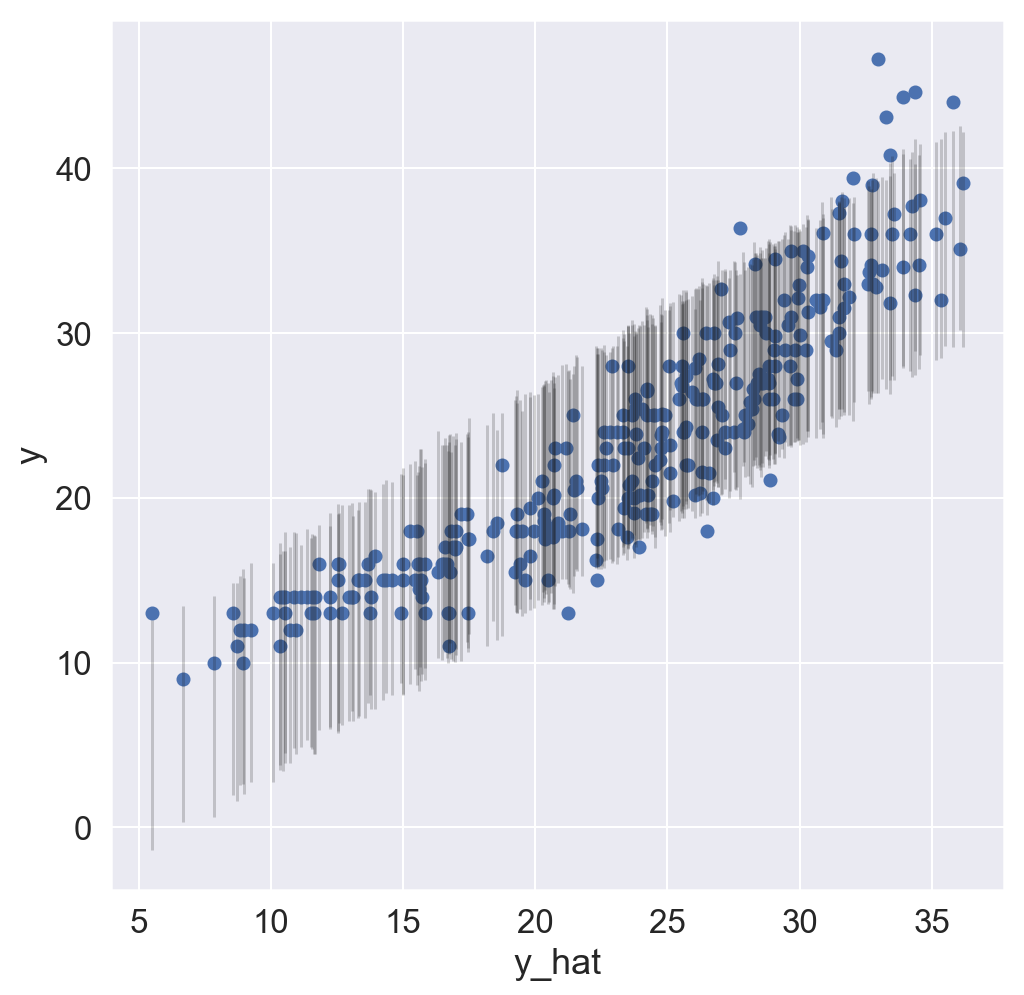

In [49]:
preds, fig, ax = prediction_scoring(y_train.values, trace, model)

### Evaluation on the test set

In [50]:
# update the shared predictor variable referring to the test data
predictors_shared.set_value(X_test[predictors].values)
outcome_shared.set_value(y_test.values)

100%|██████████| 1000/1000 [00:10<00:00, 92.85it/s]


sklearn r2: 0.8253116427883639
pym3 r2: 0.736135


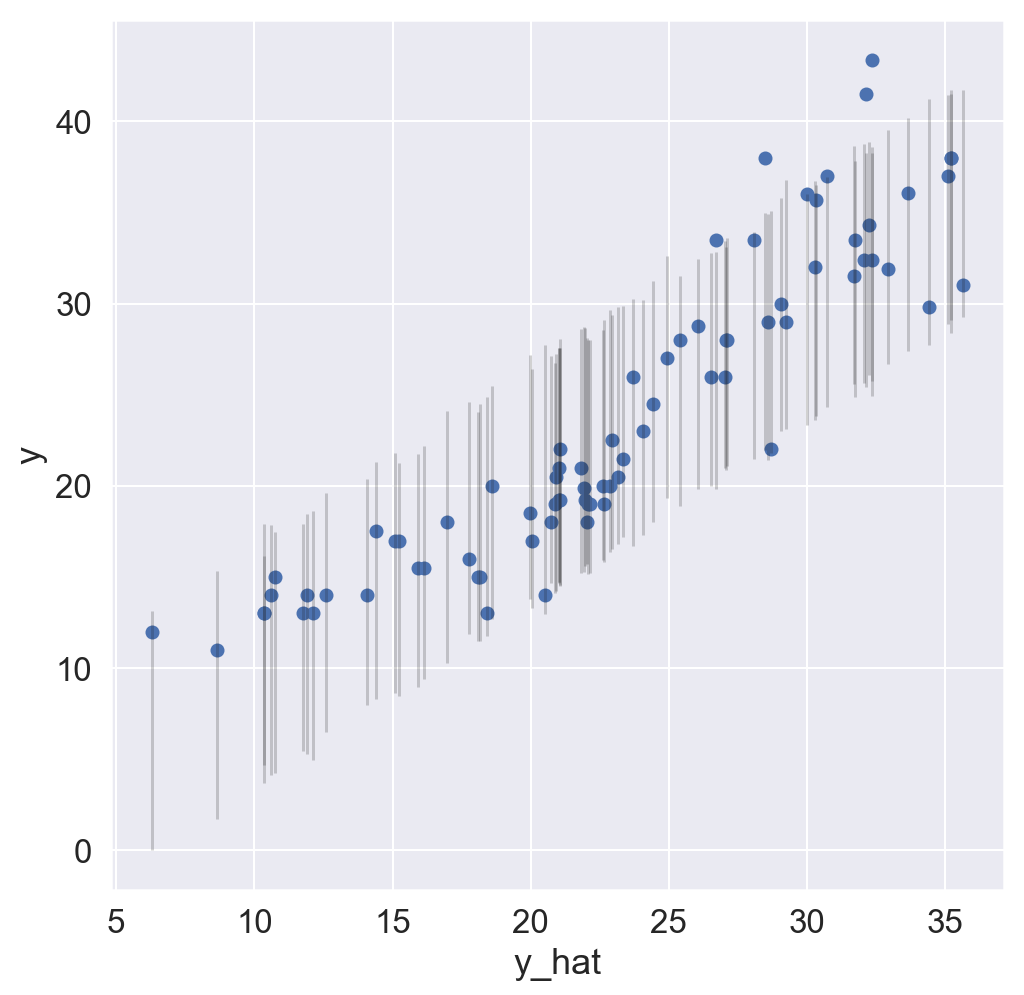

In [51]:
preds, fig, ax = prediction_scoring(y_test.values, trace, model)